In [2]:
import os
import pandas as pd
import io
import boto3
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

def load_credentials():
    """
    Load Supabase credentials from .env file.
    """
    return {
        "access_key_id": os.getenv("SUPABASE_ACCESS_KEY_ID"),
        "secret_access_key": os.getenv("SUPABASE_SECRET_ACCESS_KEY"),
        "endpoint_url": os.getenv("SUPABASE_ENDPOINT"),
        "region_name": os.getenv("SUPABASE_REGION"),
        "bucket_name": os.getenv("SUPABASE_BUCKET_NAME"),
    }

def read_and_merge_csv_from_supabase_s3(subfolders, credentials):
    """
    Read CSV files from specified subfolders in a Supabase S3-compatible storage.
    Outer join all CSV files in each subfolder and return a DataFrame per subfolder.

    Parameters:
    -----------
    subfolders : list
        List of subfolders to search for CSV files.
    credentials : dict
        Dictionary containing Supabase S3 credentials.

    Returns:
    --------
    list
        A list of DataFrames, one per subfolder.
    """
    # Create S3 client with custom endpoint
    s3_client = boto3.client(
        "s3",
        aws_access_key_id=credentials["access_key_id"],
        aws_secret_access_key=credentials["secret_access_key"],
        endpoint_url=credentials["endpoint_url"],
        region_name=credentials["region_name"],
        config=boto3.session.Config(signature_version="s3v4"),
    )
    
    dataframes = []
    
    for subfolder in subfolders:
        merged_df = pd.DataFrame()
        try:
            paginator = s3_client.get_paginator("list_objects_v2")
            for page in paginator.paginate(Bucket=credentials["bucket_name"], Prefix=f"{subfolder}/"):
                if "Contents" not in page:
                    continue
                for obj in page["Contents"]:
                    if obj["Key"].lower().endswith(".csv"):
                        try:
                            # Fetch the CSV file
                            response = s3_client.get_object(Bucket=credentials["bucket_name"], Key=obj["Key"])
                            csv_content = response["Body"].read()
                            df = pd.read_csv(io.BytesIO(csv_content))

                            # Outer join with the merged DataFrame
                            if merged_df.empty:
                                merged_df = df
                            else:
                                merged_df = pd.merge(merged_df, df, how="outer")
                        except Exception as e:
                            print(f"Error processing file {obj['Key']}: {e}")
            dataframes.append(merged_df)
        except Exception as e:
            print(f"Error processing subfolder {subfolder}: {e}")
            dataframes.append(pd.DataFrame())  # Add an empty DataFrame in case of error for consistency

    return dataframes


def main():
    # Load credentials from .env
    credentials = load_credentials()
    
    # Define subfolders
    subfolders = ["raw/auchan", "raw/pingo_doce", "raw/continente"]
    
    # Read and merge data
    merged_dataframes = read_and_merge_csv_from_supabase_s3(subfolders, credentials)
    
    return merged_dataframes


In [3]:
dfs = main()
dfs

Error processing file raw/continente/20241113/biologicos.csv: You are trying to merge on object and float64 columns for key 'Product ID'. If you wish to proceed you should use pd.concat
Error processing file raw/continente/20241115/biologicos.csv: You are trying to merge on object and float64 columns for key 'Product ID'. If you wish to proceed you should use pd.concat
Error processing file raw/continente/20241116/bebe.csv: You are trying to merge on object and int64 columns for key 'Product ID'. If you wish to proceed you should use pd.concat
Error processing file raw/continente/20241116/biologicos.csv: You are trying to merge on object and float64 columns for key 'Product ID'. If you wish to proceed you should use pd.concat
Error processing file raw/continente/20241120/bebe.csv: You are trying to merge on object and int64 columns for key 'Product ID'. If you wish to proceed you should use pd.concat
Error processing file raw/continente/20241120/biologicos.csv: You are trying to merge 

[        product_id  ... timestamp
 0          3074118  ...  20241113
 1           293295  ...  20241113
 2          2878683  ...  20241113
 3          2736681  ...  20241113
 4          3009129  ...  20241113
 ...            ...  ...       ...
 283659      763248  ...  20241126
 283660     3771505  ...  20241126
 283661     3771462  ...  20241126
 283662     3830541  ...  20241126
 283663     3771503  ...  20241126
 
 [283664 rows x 13 columns],
                                              product_id  ...        timestamp
 0                                 agua-pingo-doce-33-cl  ...  20241113_173400
 1                                 agua-pingo-doce-50-cl  ...  20241113_173400
 2                   iced-tea-pessego-pingo-doce-6x20-cl  ...  20241113_173400
 3                         agua-com-gas-pingo-doce-25-cl  ...  20241113_173400
 4                   nectar-de-8-frutos-pingo-doce-20-cl  ...  20241113_173400
 ...                                                 ...  ...              

In [26]:
auchan, pingo_doce, continente = dfs

In [6]:
auchan.nunique()

product_id            32029
product_name          32072
product_price          2128
product_category         25
product_category2       153
product_category3       566
product_image             1
product_urls          32485
product_ratings       32029
product_labels           36
product_promotions        0
source                    1
timestamp                13
dtype: int64

In [27]:
auchan = auchan[auchan["timestamp"] == 20241113]
auchan

,product_id,product_name,product_price,product_category,product_category2,product_category3,product_image,product_urls,product_ratings,product_labels,product_promotions,source,timestamp
0,3074118,requeijão de ovelha auchan à mesa em portugal ...,1.59,Produtos Frescos,Queijaria,"Queijo Fresco,Requeijão e Mozzarella",,"{""productUrl"":""/pt/produtos-frescos/queijaria/...",3074118,"[{'alt': 'Produto Nacional', 'title': 'Produto...",NaN,auchan,20241113
1,293295,polen serra de portel 220g,6.95,Alimentação,Mercearia,"Cremes, Compotas e Mel",,"{""productUrl"":""/pt/alimentacao/mercearia/creme...",293295,"[{'alt': 'Produto Nacional', 'title': 'Produto...",NaN,auchan,20241113
2,2878683,caldeirada peixe peniche congelada 800 g,6.99,Alimentação,Congelados,Peixe,,"{""productUrl"":""/pt/alimentacao/congelados/peix...",2878683,"[{'alt': 'Produto Nacional', 'title': 'Produto...",NaN,auchan,20241113
3,2736681,sardinha nacional peniche congelada 800 g,5.99,Alimentação,Congelados,Peixe,,"{""productUrl"":""/pt/alimentacao/congelados/peix...",2736681,"[{'alt': 'Produto Nacional', 'title': 'Produto...",NaN,auchan,20241113
4,3009129,bebida auchan aveia s/açúcares 1l,0.95,Alimentação,Produtos Lácteos,Bebidas Vegetais,,"{""productUrl"":""/pt/alimentacao/produtos-lacteo...",3009129,[],NaN,auchan,20241113
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20752,3577548,protectores adesivos auchan para mobilia sorti...,5.00,Marcas Auchan,Auchan,NaN,,"{""productUrl"":""/pt/marcas-auchan/auchan/protec...",3577548,[],NaN,auchan,20241113
20753,3593444,pano da louça 180g actuel tijolo 100% algodão ...,3.49,Casa e Jardim,Cozinha,"Panos, Aventais e Pegas",,"{""productUrl"":""/pt/casa-e-jardim/cozinha/panos...",3593444,[],NaN,auchan,20241113
20754,3793798,cabo usb a- lightning qilive 600161193 mfi lit...,14.99,Tecnologia e Eletrodomésticos,Tecnologia,Telemóveis e Wearables,,"{""productUrl"":""/pt/tecnologia-e-eletrodomestic...",3793798,[],NaN,auchan,20241113
20755,3415881,cadeado auchan aluminio com 2 chaves 20mm,4.45,Marcas Auchan,Auchan,NaN,,"{""productUrl"":""/pt/marcas-auchan/auchan/cadead...",3415881,[],NaN,auchan,20241113


EDA for product_category:


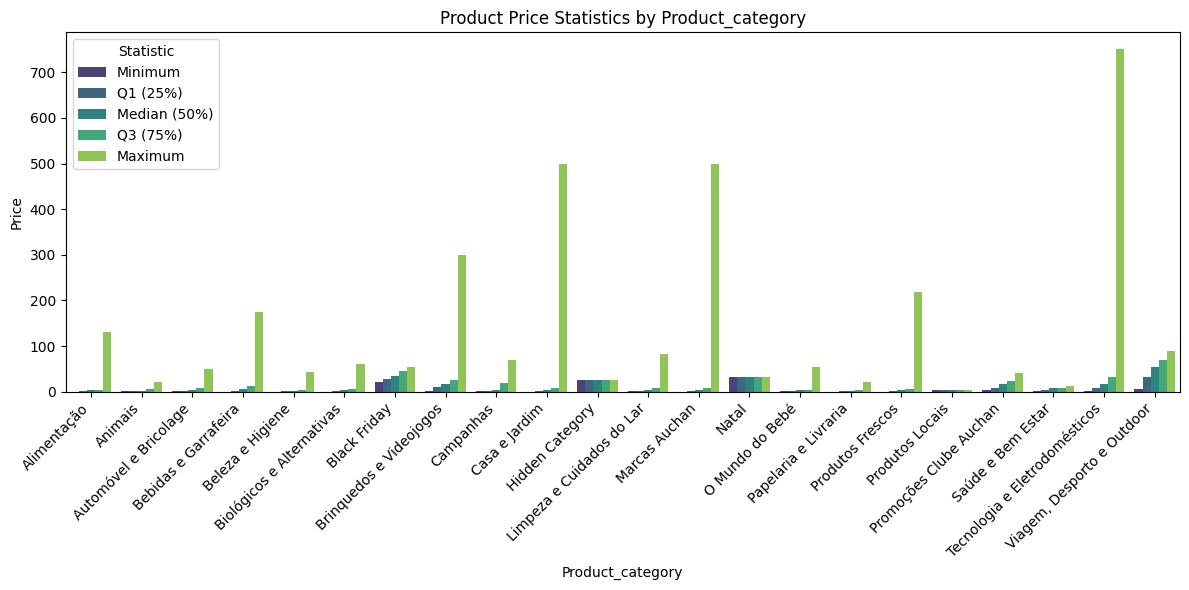

In [28]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate quantiles and plot for a given category column
def plot_price_statistics(df, category_column):
    # Group by the category column and calculate statistics
    grouped = df.groupby(category_column)["product_price"].describe(percentiles=[0.25, 0.5, 0.75])
    
    # Reset index for easier manipulation
    grouped = grouped.reset_index()
    
    # Rename columns for clarity
    grouped = grouped.rename(columns={
        "25%": "Q1 (25%)",
        "50%": "Median (50%)",
        "75%": "Q3 (75%)",
        "min": "Minimum",
        "max": "Maximum",
        "mean": "Mean"
    })
    
    # Melt the DataFrame for visualization
    melted = grouped.melt(
        id_vars=[category_column],
        value_vars=["Minimum", "Q1 (25%)", "Median (50%)", "Q3 (75%)", "Maximum"],
        var_name="Statistic",
        value_name="Price"
    )
    
    # Plot using seaborn
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=melted,
        x=category_column,
        y="Price",
        hue="Statistic",
        palette="viridis"
    )
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Product Price Statistics by {category_column.capitalize()}")
    plt.xlabel(category_column.capitalize())
    plt.ylabel("Price")
    plt.legend(title="Statistic")
    plt.tight_layout()
    plt.show()

# Plot for product_category
print("EDA for product_category:")
plot_price_statistics(auchan, "product_category")


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4664\881526813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auchan["product_price"] = pd.to_numeric(auchan["product_price"], errors="coerce")


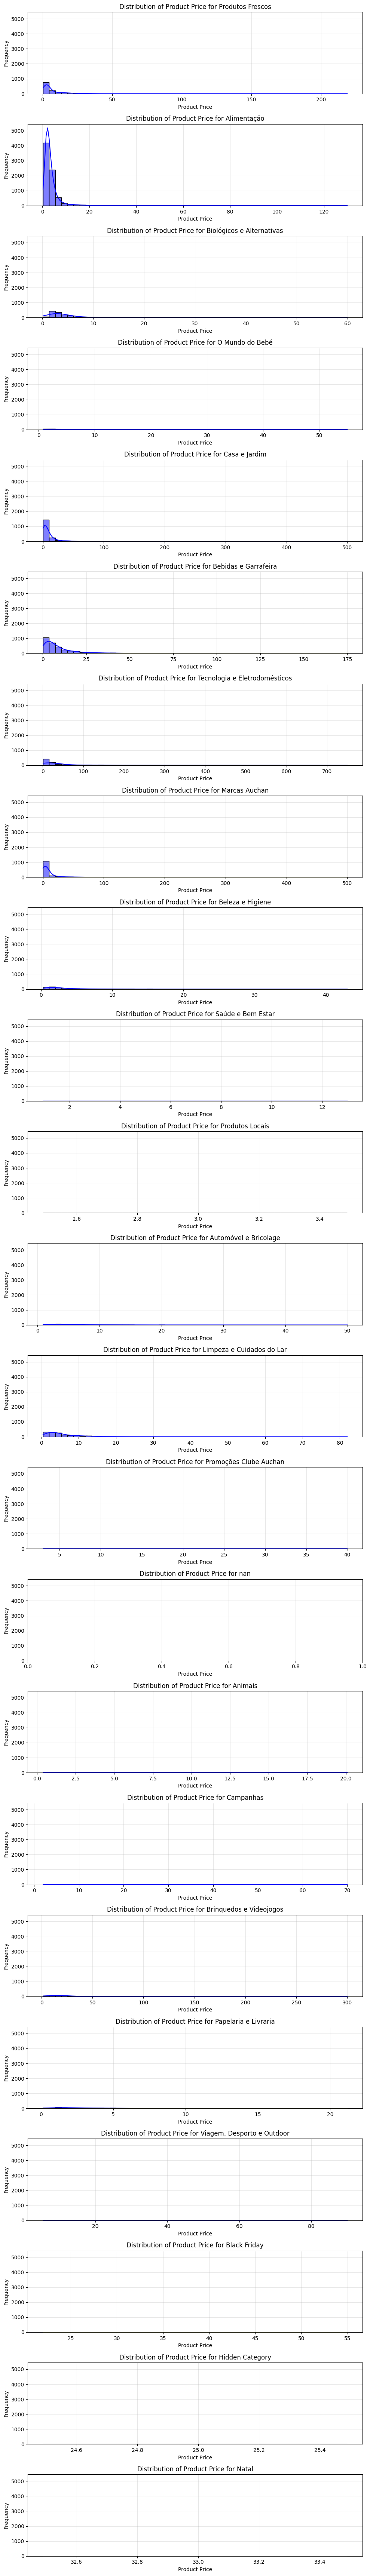

In [29]:
# Ensure 'product_price' is numeric and drop NaNs in the auchan dataframe
auchan["product_price"] = pd.to_numeric(auchan["product_price"], errors="coerce")
auchan = auchan.dropna(subset=["product_price"])

# Get unique product categories
categories = auchan["product_category"].unique()

# Calculate shared y-axis limit
max_y = max(
    sns.histplot(
        auchan[auchan["product_category"] == category]["product_price"], bins=30
    ).get_yticks().max()
    for category in categories
)
plt.close()  # Close temporary plot to avoid display clutter

# Plot distributions with shared y-axis scale
fig, axes = plt.subplots(len(categories), 1, figsize=(10, len(categories) * 3), sharey=True)

for ax, category in zip(axes, categories):
    sns.histplot(
        auchan[auchan["product_category"] == category]["product_price"],
        kde=True,
        color="blue",
        bins=50,
        ax=ax,
    )
    ax.set_title(f"Distribution of Product Price for {category}")
    ax.set_xlabel("Product Price")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)
    # ax.set_ylim(0, max_y)

plt.tight_layout()
plt.show()

In [30]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    """
    Preprocess text for NLP analysis
    - Convert to lowercase
    - Remove special characters
    - Remove numbers
    - Remove stopwords
    """
    # Ensure text is a string
    if not isinstance(text, str):
        text = str(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    return tokens

def analyze_product_names(df):
    """
    Analyze product names by product category
    
    Parameters:
    df (pandas.DataFrame): Input dataframe
    
    Returns:
    dict: Dictionary with product categories and their top words
    """
    # Group by product_category3 and collect product names
    grouped = df.groupby('product_category3')['product_name']
    
    # Dictionary to store results
    category_word_analysis = {}
    
    for category, product_names in grouped:
        # Collect all words across product names in this category
        all_words = []
        for name in product_names:
            all_words.extend(preprocess_text(name))
        
        # Count word frequencies
        word_freq = Counter(all_words)
        
        # Get top 10 most common words
        top_words = word_freq.most_common(10)
        
        category_word_analysis[category] = {
            'top_words': top_words,
            'total_products': len(product_names),
            'unique_words': len(set(all_words))
        }
    
    return category_word_analysis

# Example usage
def print_analysis_results(analysis):
    """
    Print the results of the product name analysis
    """
    print("Product Name Analysis by Category:\n")
    for category, details in analysis.items():
        print(f"Category: {category}")
        print(f"Total Products: {details['total_products']}")
        print(f"Unique Words: {details['unique_words']}")
        print("Top Words:")
        for word, count in details['top_words']:
            print(f"  - {word}: {count}")
        print("\n" + "="*50 + "\n")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Miguel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Miguel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
res_nlp = analyze_product_names(auchan)
print_analysis_results(res_nlp)

Product Name Analysis by Category:

Category: 100% Fruta
Total Products: 34
Unique Words: 31
Top Words:
  - sumo: 34
  - l: 23
  - compal: 11
  - laranja: 10
  - auchan: 10
  - santal: 7
  - ml: 6
  - multifrutos: 4
  - polegar: 4
  - xl: 3


Category: Absorve Odores, Anti Humidade e Outros (Gel)
Total Products: 17
Unique Words: 38
Top Words:
  - ambientador: 17
  - un: 7
  - casa: 6
  - banho: 6
  - ambipur: 6
  - ml: 5
  - flores: 4
  - glade: 4
  - auchan: 4
  - mecha: 3


Category: Abóbora, Cenoura e Alho Francês
Total Products: 9
Unique Words: 19
Top Words:
  - kg: 5
  - auchan: 5
  - bio: 4
  - g: 4
  - abbora: 4
  - cultivamos: 4
  - bom: 4
  - cenoura: 3
  - alho: 2
  - francs: 2


Category: Acessórios Banho
Total Products: 10
Unique Words: 30
Top Words:
  - cosmia: 10
  - un: 10
  - esponja: 5
  - banho: 4
  - de: 4
  - luva: 3
  - esfoliante: 3
  - suave: 2
  - peles: 2
  - delicadas: 2


Category: Acessórios Beleza
Total Products: 19
Unique Words: 52
Top Words:
  - cosmia: 1

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords

# Preprocessing and error handling
def preprocess_and_clean_data(df):
    """
    Preprocess and clean the dataframe for classification
    """
    # Remove rows with NaN in critical columns
    df = df.dropna(subset=['product_name', 'product_category3'])
    
    # Remove very rare categories (less than 5 occurrences)
    category_counts = df['product_category3'].value_counts()
    frequent_categories = category_counts[category_counts >= 5].index
    df = df[df['product_category3'].isin(frequent_categories)]
    
    return df

class RobustAuchanProductClassifier:
    def __init__(self, max_features=5000):
        # Preprocessing components
        self.label_encoder = LabelEncoder()
        
        # Text preprocessing method
        self.vectorizer = TfidfVectorizer(
            preprocessor=self.preprocess_text,
            max_features=max_features,
            ngram_range=(1, 2)  # Consider both unigrams and bigrams
        )
        
        # Classifier pipeline
        self.classifier = Pipeline([
            ('tfidf', self.vectorizer),
            ('clf', OneVsRestClassifier(LinearSVC(random_state=42)))
        ])

    def preprocess_text(self, text):
        """
        Advanced text preprocessing
        """
        # Ensure text is a string
        if not isinstance(text, str):
            text = str(text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespaces
        text = ' '.join(text.split())
        
        return text

    def train_classifier(self, X, y):
        """
        Train the classifier with robust error handling
        """
        # Encode target labels
        y_encoded = self.label_encoder.fit_transform(y)
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42
        )
        
        # Train the classifier
        self.classifier.fit(X_train, y_train)
        
        # Predict
        y_pred = self.classifier.predict(X_test)
        
        # Get unique labels from test set
        unique_labels = np.unique(y_test)
        
        # Print detailed classification report
        print("Classification Report:")
        print(classification_report(
            y_test, 
            y_pred, 
            labels=unique_labels,
            target_names=self.label_encoder.inverse_transform(unique_labels)
        ))
        
        # Confusion Matrix
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        
        return self

    def predict_category(self, product_names):
        """
        Predict categories for given product names
        """
        # Predict categories
        predictions = self.classifier.predict(product_names)
        
        # Decode predictions back to original labels
        return self.label_encoder.inverse_transform(predictions)

def run_auchan_classifier(auchan):
    # Preprocess and clean the data
    cleaned_df = preprocess_and_clean_data(auchan)
    
    # Initialize the classifier
    classifier = RobustAuchanProductClassifier()
    
    # Train the classifier
    classifier.train_classifier(
        X=cleaned_df['product_name'], 
        y=cleaned_df['product_category3']
    )
    
    # Demonstrate prediction
    sample_products = cleaned_df['product_name'].sample(5).tolist()
    predictions = classifier.predict_category(sample_products)
    
    print("\nSample Predictions:")
    for product, pred in zip(sample_products, predictions):
        print(f"Product: {product}")
        print(f"Predicted Category: {pred}\n")
    
    return classifier

# Cross-validation with robust handling
def cross_validation_analysis(auchan, k_folds=5):
    """
    Perform cross-validation to ensure model robustness
    """
    from sklearn.model_selection import cross_val_score
    
    # Preprocess and clean the data
    cleaned_df = preprocess_and_clean_data(auchan)
    
    # Initialize the classifier
    classifier = RobustAuchanProductClassifier()
    
    # Encode labels
    y_encoded = classifier.label_encoder.fit_transform(cleaned_df['product_category3'])
    
    # Perform cross-validation
    cv_scores = cross_val_score(
        classifier.classifier, 
        cleaned_df['product_name'], 
        y_encoded,
        cv=k_folds,
        scoring='f1_macro'
    )
    
    print("\nCross-Validation Results:")
    print(f"F1 Scores: {cv_scores}")
    print(f"Mean F1 Score: {cv_scores.mean():.4f}")
    print(f"Standard Deviation: {cv_scores.std():.4f}")

In [37]:
_cl = run_auchan_classifier(auchan)
cross_validation_analysis(auchan)

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value

Classification Report:
                                              precision    recall  f1-score   support

                                  100% Fruta       0.86      0.86      0.86         7
Absorve Odores, Anti Humidade e Outros (Gel)       1.00      1.00      1.00         3
             Abóbora, Cenoura e Alho Francês       0.50      0.50      0.50         4
                            Acessórios Banho       0.67      1.00      0.80         2
                           Acessórios Beleza       1.00      0.50      0.67         4
                           Acessórios Cabelo       0.80      0.94      0.86        17
                       Acessórios de Limpeza       0.81      0.92      0.86        24
                    Acessórios e Consumíveis       1.00      0.50      0.67         2
           Acessórios para Bonecos e Bonecas       0.00      0.00      0.00         2
               Acessórios para Casa de Banho       0.95      0.95      0.95        22
                      Aditivos

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,


Cross-Validation Results:
F1 Scores: [0.66686756 0.74497704 0.74008588 0.73997934 0.67850196]
Mean F1 Score: 0.7141
Standard Deviation: 0.0340


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import re
import random

class TextAugmentation:
    @staticmethod
    def synonym_replacement(text, n=1):
        """
        Replace words with synonyms
        """
        from nltk.corpus import wordnet
        
        # Tokenize the text
        words = text.split()
        new_words = words.copy()
        
        # Function to get synonyms
        def get_synonyms(word):
            synonyms = []
            for syn in wordnet.synsets(word):
                for lemma in syn.lemmas():
                    synonyms.append(lemma.name())
            return list(set(synonyms))
        
        # Replace random words with synonyms
        for _ in range(n):
            if len(new_words) > 0:
                # Choose a random word
                random_word_index = random.randint(0, len(new_words) - 1)
                random_word = new_words[random_word_index]
                
                # Get synonyms
                synonyms = get_synonyms(random_word)
                
                # Replace if synonyms exist
                if synonyms:
                    synonym = random.choice(synonyms).replace('_', ' ')
                    new_words[random_word_index] = synonym
        
        return ' '.join(new_words)
    
    @staticmethod
    def back_translation(text):
        """
        Simulate back translation using simple transformations
        """
        # Word-level transformations
        transformations = {
            'big': 'large',
            'small': 'tiny',
            'good': 'excellent',
            'bad': 'poor',
            'red': 'crimson',
            'blue': 'azure'
        }
        
        # Split and transform words
        words = text.split()
        transformed_words = [transformations.get(word.lower(), word) for word in words]
        
        return ' '.join(transformed_words)
    
    @staticmethod
    def random_insertion(text, n=1):
        """
        Insert random words into the text
        """
        # Common product-related words for insertion
        product_words = [
            'fresh', 'premium', 'quality', 'classic', 
            'original', 'special', 'extra', 'pure'
        ]
        
        words = text.split()
        for _ in range(n):
            # Choose a random position
            pos = random.randint(0, len(words))
            # Choose a random word to insert
            word_to_insert = random.choice(product_words)
            words.insert(pos, word_to_insert)
        
        return ' '.join(words)

def augment_training_data(X_train, y_train, augmentation_factor=2):
    """
    Apply data augmentation specifically to training data
    
    Parameters:
    X_train (array-like): Training product names
    y_train (array-like): Training labels
    augmentation_factor (int): How many augmented samples to create per original sample
    
    Returns:
    Augmented X_train and y_train
    """
    # Group training data by category
    category_groups = {}
    for xi, yi in zip(X_train, y_train):
        if yi not in category_groups:
            category_groups[yi] = []
        category_groups[yi].append(xi)
    
    # Augmented data storage
    augmented_X = list(X_train)
    augmented_y = list(y_train)
    
    # Augmentation methods
    augmentation_methods = [
        TextAugmentation.synonym_replacement,
        TextAugmentation.back_translation,
        TextAugmentation.random_insertion
    ]
    
    # Augmentation for each category
    for category, samples in category_groups.items():
        # Determine number of augmentations needed
        for original in samples:
            for _ in range(augmentation_factor):
                # Choose a random augmentation method
                augmentation_method = random.choice(augmentation_methods)
                
                # Apply augmentation
                augmented_sample = augmentation_method(original)
                
                # Add augmented sample
                augmented_X.append(augmented_sample)
                augmented_y.append(category)
    
    return augmented_X, augmented_y

def train_augmented_classifier(auchan, augmentation_factor=2, column_to_predict = 'product_category3'):
    """
    Train classifier with augmentation applied only to training data
    
    Parameters:
    auchan (DataFrame): Input dataframe
    augmentation_factor (int): Number of augmented samples per original sample
    
    Returns:
    Trained classifier
    """
    # Preprocess and clean the data
    cleaned_df = auchan.dropna(subset=['product_name', 'product_category3'])
    
    # Remove very rare categories (less than 5 occurrences)
    category_counts = cleaned_df['product_category3'].value_counts()
    frequent_categories = category_counts[category_counts >= 5].index
    cleaned_df = cleaned_df[cleaned_df['product_category3'].isin(frequent_categories)]
    
    # Prepare data
    X = cleaned_df['product_name']
    y = cleaned_df['product_category3']
    
    # Initial train-test split WITHOUT augmentation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Apply augmentation ONLY to training data
    X_train_augmented, y_train_augmented = augment_training_data(
        X_train, y_train, 
        augmentation_factor=augmentation_factor
    )
    
    # Initialize the classifier
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_augmented)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Vectorizer and Classifier
    vectorizer = TfidfVectorizer(
        preprocessor=lambda x: x.lower(),
        max_features=5000,
        ngram_range=(1, 2)
    )
    
    classifier = Pipeline([
        ('tfidf', vectorizer),
        ('clf', OneVsRestClassifier(LinearSVC(random_state=42)))
    ])
    
    # Train the classifier on augmented training data
    classifier.fit(X_train_augmented, y_train_encoded)
    
    # Predict and evaluate
    y_pred = classifier.predict(X_test)
    
    # Unique labels from test set
    unique_labels = np.unique(y_test_encoded)
    
    # Print classification report
    print("Classification Report (Augmented Training Data):")
    print(classification_report(
        y_test_encoded, 
        y_pred, 
        labels=unique_labels,
        target_names=label_encoder.inverse_transform(unique_labels)
    ))
    
    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_encoded, y_pred))
    
    # Sample predictions
    sample_products = X_test.sample(5).tolist()
    sample_predictions = classifier.predict(sample_products)
    
    print("\nSample Predictions:")
    for product, pred in zip(sample_products, 
                             label_encoder.inverse_transform(sample_predictions)):
        print(f"Product: {product}")
        print(f"Predicted Category: {pred}\n")
    
    return classifier

In [45]:
classifier = train_augmented_classifier(auchan, augmentation_factor=2)

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value

Classification Report (Augmented Training Data):
                                              precision    recall  f1-score   support

                                  100% Fruta       1.00      0.86      0.92         7
Absorve Odores, Anti Humidade e Outros (Gel)       1.00      1.00      1.00         3
             Abóbora, Cenoura e Alho Francês       1.00      0.50      0.67         4
                            Acessórios Banho       0.67      1.00      0.80         2
                           Acessórios Beleza       0.40      0.50      0.44         4
                           Acessórios Cabelo       0.89      1.00      0.94        17
                       Acessórios de Limpeza       0.69      0.92      0.79        24
                    Acessórios e Consumíveis       0.00      0.00      0.00         2
           Acessórios para Bonecos e Bonecas       0.00      0.00      0.00         2
               Acessórios para Casa de Banho       1.00      0.95      0.98        22
    

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,